In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Example 1

In this example, we will apply RNN to a time series.

In [24]:
File_path="/content/sample_data/AirPassengers.csv"
#File_path="AirPassengers.csv"
data = pd.read_csv(File_path,parse_dates=True)  #index_col='Month', parse_dates=True
data["Month"] = pd.to_datetime(data["Month"],format='%Y-%m')
data.index = data["Month"]
data.head()

,Month,#Passengers
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


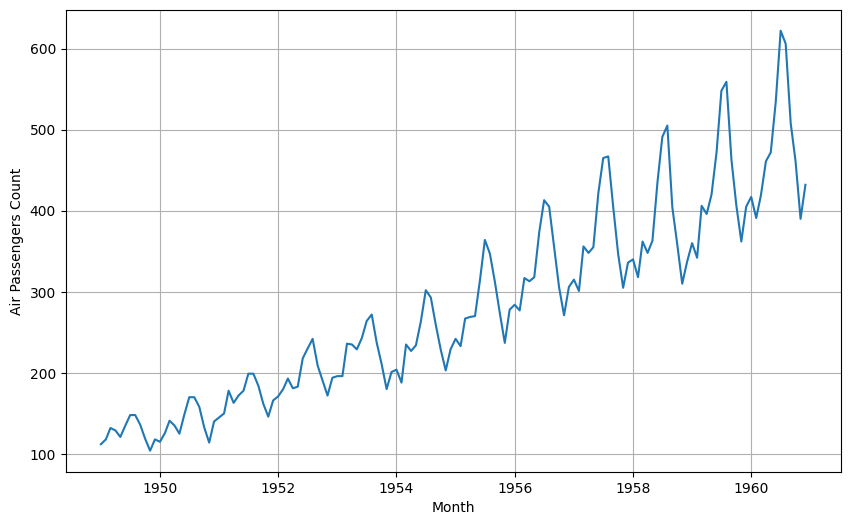

In [25]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")
plt.plot(data['#Passengers'])
plt.grid()
plt.show()

In [227]:
datatorch=torch.Tensor(data.iloc[:,1])
datatorch=torch.nn.functional.normalize(datatorch,dim=0)
datatorch

<ipython-input-227-c3f99228738b>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  datatorch=torch.Tensor(data.iloc[:,1])


tensor([0.0306, 0.0323, 0.0361, 0.0353, 0.0331, 0.0369, 0.0405, 0.0405, 0.0372,
        0.0325, 0.0284, 0.0323, 0.0314, 0.0345, 0.0386, 0.0369, 0.0342, 0.0407,
        0.0465, 0.0465, 0.0432, 0.0364, 0.0312, 0.0383, 0.0397, 0.0410, 0.0487,
        0.0446, 0.0470, 0.0487, 0.0544, 0.0544, 0.0503, 0.0443, 0.0399, 0.0454,
        0.0468, 0.0492, 0.0528, 0.0495, 0.0500, 0.0596, 0.0629, 0.0662, 0.0572,
        0.0522, 0.0470, 0.0531, 0.0536, 0.0536, 0.0645, 0.0643, 0.0626, 0.0665,
        0.0722, 0.0744, 0.0648, 0.0577, 0.0492, 0.0550, 0.0558, 0.0514, 0.0643,
        0.0621, 0.0640, 0.0722, 0.0826, 0.0801, 0.0708, 0.0626, 0.0555, 0.0626,
        0.0662, 0.0637, 0.0730, 0.0736, 0.0738, 0.0861, 0.0995, 0.0949, 0.0853,
        0.0749, 0.0648, 0.0760, 0.0777, 0.0758, 0.0867, 0.0856, 0.0870, 0.1023,
        0.1129, 0.1108, 0.0971, 0.0837, 0.0741, 0.0837, 0.0861, 0.0823, 0.0974,
        0.0952, 0.0971, 0.1154, 0.1272, 0.1277, 0.1105, 0.0949, 0.0834, 0.0919,
        0.0930, 0.0870, 0.0990, 0.0952, 

In [228]:
split_idx=48
x_train, x_test=datatorch[:-split_idx], datatorch[-split_idx:]


def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.stack(X), torch.stack(y)


seq_length = 48
X, y = create_dataset(x_train, seq_length)

In [229]:
X.shape, y.shape

(torch.Size([48, 48]), torch.Size([48]))

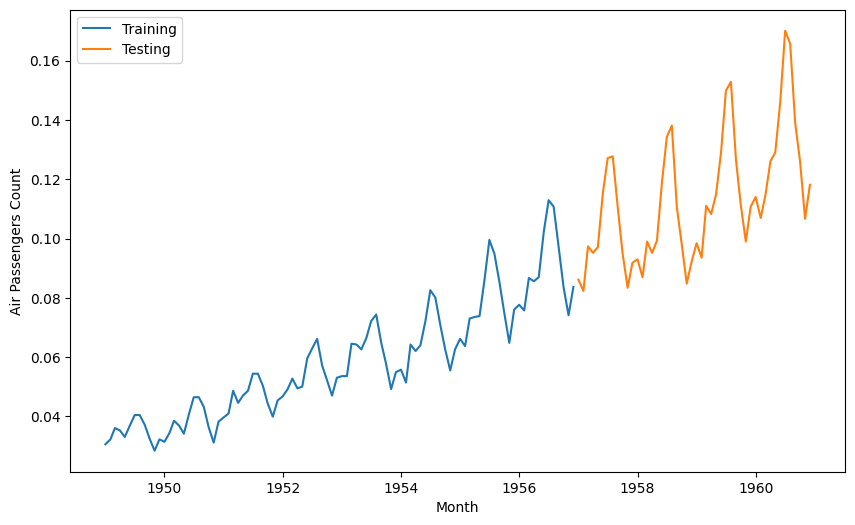

In [230]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'][:-split_idx],x_train, label='Training')
plt.plot(data['Month'][-split_idx:],x_test, label='Testing')
plt.legend()
plt.show()

Note that `hidden_size` is the size of hidden RNN layer, and not the amount of time steps we take. Amount of time steps depends on our input. In our example, each sample is of size 24 and so we will have 24 time steps for each input.

In [231]:
# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
model = SimpleRNN(input_size=1, hidden_size=48, output_size=1)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
epochs = 1500
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X.unsqueeze(2))
    loss = criterion(output, y.unsqueeze(1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    predictions = model(X.unsqueeze(2))

Epoch: 0, Loss: 0.1742
Epoch: 100, Loss: 0.0107
Epoch: 200, Loss: 0.0086
Epoch: 300, Loss: 0.0077
Epoch: 400, Loss: 0.0069
Epoch: 500, Loss: 0.0069
Epoch: 600, Loss: 0.0068
Epoch: 700, Loss: 0.0070
Epoch: 800, Loss: 0.0051
Epoch: 900, Loss: 0.0049
Epoch: 1000, Loss: 0.0044
Epoch: 1100, Loss: 0.0043
Epoch: 1200, Loss: 0.0042
Epoch: 1300, Loss: 0.0038
Epoch: 1400, Loss: 0.0033


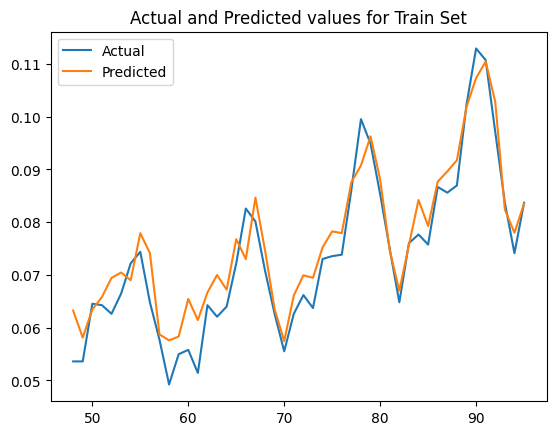

In [232]:
plt.plot(np.arange(seq_length, len(x_train)),x_train[seq_length:].numpy(), label='Actual')
plt.plot(np.arange(seq_length, len(x_train)), predictions.numpy(), label='Predicted')
plt.title("Actual and Predicted values for Train Set")
plt.legend()
plt.show()

In [233]:
predictions=[]
test_set=x_train[-seq_length:]
with torch.no_grad():
    for i in range(split_idx):
        predictions.append(model(test_set[None,:].unsqueeze(2)).squeeze().numpy())  #adding None for batch dimension.
        test_set=torch.tensor([*test_set,predictions[i]])  # Adding element to tensor
        test_set=test_set[1:]

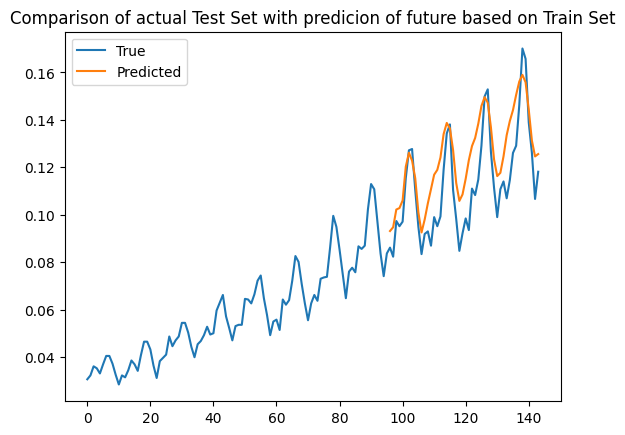

In [234]:
plt.plot(datatorch, label='True')
plt.plot(np.arange(len(datatorch)-split_idx, len(datatorch)), predictions, label='Predicted')
plt.legend()
plt.title("Comparison of actual Test Set with predicion of future based on Train Set")
plt.show()

### Example 2

In the next example, we will look inside RNN. We will use only linear functions and use training loop to connected everything like RNN. In this example, we will train our RNN to guess which last names belong to which nationality based on name structure.

First a few helpful functions:

In [176]:
import io
import os
import unicodedata
import string
import glob
import random


ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII.
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/Data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [66]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [67]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

In [68]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [69]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [70]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 1.6463 Rosario / Portuguese CORRECT
10000 10.0 0.2743 Poplawski / Polish CORRECT
15000 15.0 0.5926 Lawrenz / German CORRECT
20000 20.0 1.8412 Pettigrew / English WRONG (French)
25000 25.0 0.6699 Lorenzen / German CORRECT
30000 30.0 6.1113 Verre / French WRONG (Russian)
35000 35.0 2.6913 Mencher / Dutch WRONG (Polish)
40000 40.0 1.4167 Nam / Vietnamese WRONG (Korean)
45000 45.0 0.0107 Xie / Chinese CORRECT
50000 50.0 0.0390 Tieu / Vietnamese CORRECT
55000 55.00000000000001 2.0977 Sitta / Portuguese WRONG (Czech)
60000 60.0 0.0065 Jigalev / Russian CORRECT
65000 65.0 2.6782 Cao / Korean WRONG (Vietnamese)
70000 70.0 0.5377 Haddad / Arabic CORRECT
75000 75.0 0.1439 Dam / Vietnamese CORRECT
80000 80.0 4.6312 Courtemanche / Irish WRONG (French)
85000 85.0 0.4802 Sokal / Polish CORRECT
90000 90.0 1.0394 Vandroogenbroeck / Dutch CORRECT
95000 95.0 2.0660 Shaw / Chinese WRONG (Scottish)
100000 100.0 2.5893 Mateu / French WRONG (Spanish)


Let's see how it performs:

In [71]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

In [90]:
predict("Pele")


> Pele
English
